In [ ]:
limport numpy as np
import torch
import torch.nn               as nn
import torch.distributions as tdist
import os
import sys
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.utils.spectral_norm as spectral_norm
from torch.utils.data         import Dataset, TensorDataset, DataLoader
from torchvision              import datasets
import time
from time import sleep
from tqdm import tqdm
from prettytable import PrettyTable

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/NashFPNs/TransportationNetworks/')
save_dir = './drive/MyDrive/NashFPNs/' # generated data should be saved in this path

device = "cuda"

capacity   = torch.tensor
context    = torch.tensor
action     = torch.tensor
edge       = torch.tensor
inference  = torch.tensor 
context    = torch.tensor

seed = 42
torch.manual_seed(seed)

Mounted at /content/drive


## Load Training Data

In [ ]:
# load data and split into training and testing set:
data_set = 'Berlin-Friedrichshain'
save_dir = 'drive/MyDrive/NashFPNs/TrafficTrainingData/'
state_path = save_dir + data_set + '_training_data.pth'
state = torch.load(state_path)

In [ ]:
capacity        = state['capacity']
W               = state['W']
N               = state['N']
free_flow_time  = state['free_flow_time']
x_train         = state['x_train']
x_test          = state['x_test']
d_train         = state['d_train']
d_test          = state['d_test']
b               = state['origin_destination_pairs']

context_size    = d_train.shape[1]
n_train         = d_train.shape[0]
n_test          = d_test.shape[0]

n_ODpairs       = b.shape[1]
n_edges         = x_train.shape[1]
n_nodes         = b.shape[0]

In [ ]:
train_dataset   = TensorDataset(x_train, d_train)
test_dataset    = TensorDataset(x_test, d_test)

train_batch_size = 500
test_batch_size  = 500

train_loader  = DataLoader(dataset=train_dataset,  
                            batch_size=train_batch_size, shuffle=True) 
test_loader   = DataLoader(dataset=test_dataset,   
                            batch_size=test_batch_size,  shuffle=False) 

In [ ]:
print('n_ODpairs = ', n_ODpairs, 'n_nodes = ', n_nodes, ', n_edges = ', n_edges, ', n_train = ', x_train.shape[0])

n_ODpairs =  506 n_nodes =  224 , n_edges =  523 , n_train =  5000


## Create Neural Network Architecture

In [ ]:
inference = torch.tensor
latent_variable = torch.tensor
context = torch.tensor

class Traffix_Net(nn.Module):
    def __init__(self, N, b, context_size, alpha, device):
        super().__init__()
        
        self.b = b.to(device)
        self.alpha = alpha

        U,s,VT = torch.linalg.svd(N, full_matrices=False) 
        # truncate sing. values below 1e-5
        ind = s >= 1e-5 
        s = s[ind]
        U = U[:,ind]
        VT = VT[ind, :]
        self.V = VT.t().to(device)
        self.V_Sinv_UT = VT.t().matmul( torch.diag(1/s).matmul(U.t()) ).to(device)

        self.n_nodes    = N.shape[0]
        self.n_edges    = N.shape[1] 
        self.n_ODpairs  = b.shape[1] 

        self.F_fcs_d = nn.ModuleList([nn.Linear(context_size, 100), 
                                    nn.Linear(100, 100)])
        self.fc_final_d = nn.Linear(100, self.n_edges)

        self.F_fcs = nn.ModuleList([nn.Linear(self.n_edges, 100), 
                                    nn.Linear(100, 100)])
        self.fc_final = nn.Linear(100, self.n_edges)
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.1)

        self.tanh = nn.Tanh()

        for fc in self.F_fcs: 
          torch.nn.init.zeros_(fc.weight)
        for fc in self.F_fcs_d: 
          torch.nn.init.zeros_(fc.weight)

        torch.nn.init.zeros_(self.fc_final.weight)
        torch.nn.init.zeros_(self.fc_final_d.weight)

    def device(self):
        return next(self.parameters()).data.device

    def project_C1(self, z: latent_variable) -> latent_variable: 
        return torch.clamp(z, min=0)

    def project_C2(self, z: latent_variable) -> latent_variable:
        Pz    = z - (self.V).matmul(self.V.t().matmul(z)) + self.V_Sinv_UT.matmul(self.b.unsqueeze(0))
        return Pz

    def F(self, x: action, d: context) -> action: 
      """
        Game Gradient Parameterization
          Inputs: 
            x = action with shape (batch_size x n_edges) 
            d = context with shape (batch_size x context_size)
      """

        Fd = d
        for fc in self.F_fcs_d:
          Fd = self.tanh(fc(Fd))
        Fd = self.leaky_relu(self.fc_final_d(Fd))
        
        Fx = x
        for fc in self.F_fcs: 
            Fx = self.tanh(fc(Fx)) 

        Fx = self.leaky_relu(self.fc_final(Fx))
        Fx = torch.clamp(Fx, min = -5e6, max=5e6) 
        
        return self.leaky_relu(Fx*Fd)
        

    def T(self, z: latent_variable, d: context) -> latent_variable: 
      """
        Davis-Yin Splitting described in Algorithm 3 
          Inputs: 
            z = action with shape (batch_size x n_edges x n_ODpairs) 
            d = context with shape (batch_size x context_size)
      """

        x = self.project_C1(z)
        v = torch.sum(x, dim=2)
        Fv = self.F(v,d)
        y = 2*x - z - self.alpha*Fv.unsqueeze(2)
        y = self.project_C2(y)
        z = z + y - x

        return z


    def S(self, z: latent_variable) -> inference:
      """
        Final layer that map from latent space to inference space. 
        Operations: project, sum across OD pairs, and clamp
          Inputs: 
            z = action with shape (batch_size x n_edges x n_ODpairs) 
          Output:
            v = action with shape (batch_size x n_edges)
      """

        z = self.project_C1(z)
        v = torch.sum(z, dim=2)
        return torch.clamp(v, max=1e6)

    def forward(self, d: context, eps=1.0e-2, max_depth=100, 
                depth_warning=False) -> inference: 

        with torch.no_grad():
            self.depth = 0.0

            z = torch.zeros((d.shape[0], self.n_edges, self.n_ODpairs), device=self.device())
            z_prev = z.clone()         
            
            all_samp_conv = False
            while not all_samp_conv and self.depth < max_depth:
                z_prev = z.clone()   
                z = self.T(z,d)
                diff_norm = torch.norm(z - z_prev, dim=1) 
                diff_norm = torch.norm( diff_norm, dim=1) 
                diff_norm = torch.max( diff_norm ) # take norm along the latter two dimensions then max
                self.depth += 1.0
                all_samp_conv = diff_norm <= eps
            
        if self.depth >= max_depth and depth_warning:
            print("\nWarning: Max Depth Reached - Break Forward Loop\n")

        attach_gradients = self.training
        if attach_gradients:
            z = self.T(z, d)
            return self.S(z)
        else:
            return self.S(z) 


  

In [ ]:
alpha = 1e-2
net = Traffix_Net(N, b, context_size, alpha, device)
net.to(device)
net(d_test.to(device))

tensor([[2.0349e+02, 2.0567e+02, 5.1371e+02,  ..., 8.9395e+02, 1.1399e+03,
         2.3662e-03],
        [2.0349e+02, 2.0567e+02, 5.1371e+02,  ..., 8.9395e+02, 1.1399e+03,
         2.3662e-03],
        [2.0349e+02, 2.0567e+02, 5.1371e+02,  ..., 8.9395e+02, 1.1399e+03,
         2.3662e-03],
        ...,
        [2.0349e+02, 2.0567e+02, 5.1371e+02,  ..., 8.9395e+02, 1.1399e+03,
         2.3662e-03],
        [2.0349e+02, 2.0567e+02, 5.1371e+02,  ..., 8.9395e+02, 1.1399e+03,
         2.3662e-03],
        [2.0349e+02, 2.0567e+02, 5.1371e+02,  ..., 8.9395e+02, 1.1399e+03,
         2.3662e-03]], device='cuda:0', grad_fn=<ClampBackward>)

In [ ]:
def get_trafix_score(x_pred: action, x_true: action, eps=5.0e-3, 
                     tol=1.0e-3) -> float:
  err           = torch.abs(x_pred - x_true)
  denom         = torch.abs(x_true) + tol
  rel_err       = err.div(denom)
  acc_preds     = rel_err < eps  
  num_samples   = x_true.shape[0]
  num_preds     = x_true.shape[1]
  trafix_score  = 100.0 * sum(sum(acc_preds)) / (num_samples * num_preds) 
  return trafix_score

def get_testing_stats(net, test_loader, criterion, n_edges, eps, depth, eps_traffix_score, device=device):
    test_loss = 0
    correct = 0
    rel_err = 0
    rel_err_dim0 = torch.zeros(n_edges, device=device)

    net.eval()
    with torch.no_grad():
        for _, (x_true, d_true) in enumerate(test_loader):
          
          x_true, d_true = x_true.to(device), d_true.to(device)
          batch_size = x_true.shape[0]

          x_pred = net(d_true, eps=eps, max_depth=depth) 

          test_loss += batch_size * criterion(x_pred, x_true)

          rel_err += torch.norm(x_pred - x_true)**2
          rel_err_dim0 += torch.norm(x_pred - x_true, dim=0)**2

    test_loss  /= len(test_loader.dataset)
    rel_err    = torch.sqrt(rel_err) / norm_x_test

    # rel_err_dim0 = torch.sqrt(rel_err_dim0) / norm_x_test_dim0
    # ind = rel_err_dim0 < eps_traffic_score
    # traffic_score = 100*(sum(ind)/n_edges)
    traffix_score = get_trafix_score(x_pred, x_true, eps=eps_traffix_score) 
    

    net.train()

    return test_loss, rel_err, traffix_score


In [ ]:
def model_params(net):
    table = PrettyTable(["Network Component", "# Parameters"])
    num_params = 0
    for name, parameter in net.named_parameters():
        if not parameter.requires_grad:
            continue
        table.add_row([name, parameter.numel()])
        num_params += parameter.numel()
    table.add_row(['TOTAL', num_params])
    return table

print(net)
print(model_params(net))

Traffix_Net(
  (F_fcs_d): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final_d): Linear(in_features=100, out_features=523, bias=True)
  (F_fcs): ModuleList(
    (0): Linear(in_features=523, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final): Linear(in_features=100, out_features=523, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
)
+-------------------+--------------+
| Network Component | # Parameters |
+-------------------+--------------+
|  F_fcs_d.0.weight |     1000     |
|   F_fcs_d.0.bias  |     100      |
|  F_fcs_d.1.weight |    10000     |
|   F_fcs_d.1.bias  |     100      |
| fc_final_d.weight |    52300     |
|  fc_final_d.bias  |     523      |
|   F_fcs.0.weight  |    52300     |
|    F_fcs.0.bias   |     100      |
|   F_fcs.1.weight  |    10000     |
|    F_fcs.1.bias   | 

## Set up Training

In [ ]:
# training setup
learning_rate = 1e-3
optimizer     = optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler  = optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)
eps           = 1.0e-4  # Used for stopping criterion in implicit-depth
criterion     = nn.MSELoss()
max_depth     = 50

train_loss_hist     = []
test_loss_hist      = []
traffix_score_hist  = []
rel_err_hist        = []
best_traffix_score  = 0.0

max_epochs = int(2e2)
x_test = x_test.to(device)
d_test = d_test.to(device)

# start_time_epoch = time.time() # timer for display execution time per epoch multiple
fmt        = '[{:4d}/{:4d}]: train loss = {:7.3e} | test loss = {:7.3e} | traffix score = {:7.3f}% | rel error = {:7.3e} ' 
fmt       += 'depth = {:5.1f} | lr = {:5.1e} | eps = {:5.1e} | time = {:5.1e}'
print(net)                 # display Tnet configuration
 
print('\nTraining G-FPN')
for epoch in range(max_epochs): 

  net.train()
  sleep(0.3)  # slows progress bar so it won't print on multiple lines
  loss_ave        = 0.0
  epoch_start_time = time.time()
  tot = len(train_loader)
  with tqdm(total=tot, unit=" batch", leave=False, ascii=True) as tepoch:

    tepoch.set_description("[{:3d}/{:3d}]".format(epoch+1, max_epochs))

    for _, (x_true, d_true) in enumerate(train_loader):

      x_true, d_true = x_true.to(device), d_true.to(device)

      optimizer.zero_grad()
      x_pred = net(d_true, eps=eps, max_depth=max_depth) 

      loss = criterion(x_pred, x_true)
      local_batch_size = x_true.shape[0]
      loss_ave += local_batch_size * loss

      loss.backward()
      optimizer.step()

      tepoch.update(1)
      tepoch.set_postfix(train_loss="{:5.2e}".format(loss.detach().cpu().numpy()),
                          depth="{:5.1f}".format(net.depth))

  lr_scheduler.step()
  epoch_end_time = time.time()
  time_epoch = epoch_end_time - epoch_start_time
  loss_ave = loss_ave/n_train
  train_loss_hist.append(loss_ave)

  eps_traffix_score = 5e-3
  test_loss, rel_err_test, traffix_score = get_testing_stats(net, test_loader, criterion, n_edges, eps, max_depth, eps_traffix_score)

  traffix_score_hist.append(traffix_score)
  test_loss_hist.append(test_loss)
  rel_err_hist.append(rel_err_test)

 
  print(fmt.format(epoch+1, max_epochs, loss.item(), test_loss, traffix_score, rel_err_test, net.depth, 
                    optimizer.param_groups[0]['lr'], eps, time_epoch))
  
  # ---------------------------------------------------------------------
  # Save weights
  # ---------------------------------------------------------------------
  if traffix_score > best_traffix_score:
    best_traffix_score = traffix_score
    state = {
        'test_loss_hist': test_loss_hist,
        'traffix_score_hist': traffix_score_hist,
        'rel_err_hist': rel_err_hist,
        'net_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler,
    }
    file_name = save_dir + 'FinalResults/' + data_set + '_weights.pth'
    torch.save(state, file_name)
    print('Model weights saved to ' + file_name)

  # ---------------------------------------------------------------------
  # Save history at last epoch
  # ---------------------------------------------------------------------

  if epoch+1 == max_epochs:
      state = {
        'test_loss_hist': test_loss_hist,
        'traffix_score_hist': traffix_score_hist,
        'rel_err_hist': rel_err_hist,
        'lr_scheduler': lr_scheduler,
        'eps': eps,
      }
      file_name = save_dir + 'FinalResults/' + data_set + '_history.pth'
      torch.save(state, file_name)
      print('Training history saved to ' + file_name)

Traffix_Net(
  (F_fcs_d): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final_d): Linear(in_features=100, out_features=523, bias=True)
  (F_fcs): ModuleList(
    (0): Linear(in_features=523, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_final): Linear(in_features=100, out_features=523, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (tanh): Tanh()
)

Training G-FPN


[   1/ 200]: train loss = 1.131e+02 | test loss = 1.074e+02 | traffix score =  19.820% | rel error = 1.905e-02 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[   2/ 200]: train loss = 8.139e+01 | test loss = 7.949e+01 | traffix score =  29.184% | rel error = 1.638e-02 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[   3/ 200]: train loss = 4.812e+01 | test loss = 4.233e+01 | traffix score =  42.378% | rel error = 1.195e-02 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[   4/ 200]: train loss = 1.519e+01 | test loss = 1.230e+01 | traffix score =  50.595% | rel error = 6.443e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[   5/ 200]: train loss = 4.346e+00 | test loss = 4.124e+00 | traffix score =  69.725% | rel error = 3.731e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[   6/ 200]: train loss = 2.072e+00 | test loss = 1.846e+00 | traffix score =  80.333% | rel error = 2.496e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[   7/ 200]: train loss = 1.033e+00 | test loss = 1.037e+00 | traffix score =  87.375% | rel error = 1.871e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[   8/ 200]: train loss = 8.031e-01 | test loss = 8.439e-01 | traffix score =  90.642% | rel error = 1.688e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[   9/ 200]: train loss = 6.429e-01 | test loss = 6.404e-01 | traffix score =  92.403% | rel error = 1.470e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  10/ 200]: train loss = 5.472e-01 | test loss = 5.786e-01 | traffix score =  92.948% | rel error = 1.398e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  11/ 200]: train loss = 4.818e-01 | test loss = 5.203e-01 | traffix score =  94.418% | rel error = 1.325e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  12/ 200]: train loss = 4.547e-01 | test loss = 5.030e-01 | traffix score =  94.641% | rel error = 1.303e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  13/ 200]: train loss = 4.272e-01 | test loss = 4.410e-01 | traffix score =  95.320% | rel error = 1.220e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  14/ 200]: train loss = 3.782e-01 | test loss = 4.263e-01 | traffix score =  95.783% | rel error = 1.200e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  15/ 200]: train loss = 3.705e-01 | test loss = 4.092e-01 | traffix score =  96.120% | rel error = 1.175e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  16/ 200]: train loss = 3.374e-01 | test loss = 4.070e-01 | traffix score =  95.836% | rel error = 1.172e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  17/ 200]: train loss = 3.189e-01 | test loss = 3.666e-01 | traffix score =  96.543% | rel error = 1.113e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  18/ 200]: train loss = 3.321e-01 | test loss = 3.714e-01 | traffix score =  96.455% | rel error = 1.120e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  19/ 200]: train loss = 3.067e-01 | test loss = 3.598e-01 | traffix score =  96.572% | rel error = 1.102e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  20/ 200]: train loss = 3.190e-01 | test loss = 3.554e-01 | traffix score =  96.718% | rel error = 1.095e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  21/ 200]: train loss = 2.888e-01 | test loss = 3.475e-01 | traffix score =  96.888% | rel error = 1.083e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  22/ 200]: train loss = 2.903e-01 | test loss = 3.349e-01 | traffix score =  97.015% | rel error = 1.063e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  23/ 200]: train loss = 2.452e-01 | test loss = 3.512e-01 | traffix score =  96.750% | rel error = 1.089e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[  24/ 200]: train loss = 2.664e-01 | test loss = 3.453e-01 | traffix score =  96.735% | rel error = 1.080e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  25/ 200]: train loss = 2.564e-01 | test loss = 3.273e-01 | traffix score =  97.166% | rel error = 1.051e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  26/ 200]: train loss = 2.595e-01 | test loss = 3.251e-01 | traffix score =  97.198% | rel error = 1.048e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  27/ 200]: train loss = 2.474e-01 | test loss = 3.163e-01 | traffix score =  97.269% | rel error = 1.033e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  28/ 200]: train loss = 2.564e-01 | test loss = 3.180e-01 | traffix score =  97.120% | rel error = 1.036e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  29/ 200]: train loss = 2.623e-01 | test loss = 3.134e-01 | traffix score =  97.235% | rel error = 1.029e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  30/ 200]: train loss = 2.451e-01 | test loss = 3.145e-01 | traffix score =  97.169% | rel error = 1.030e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  31/ 200]: train loss = 2.672e-01 | test loss = 3.151e-01 | traffix score =  97.301% | rel error = 1.031e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[  32/ 200]: train loss = 2.363e-01 | test loss = 3.138e-01 | traffix score =  97.208% | rel error = 1.029e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  33/ 200]: train loss = 2.541e-01 | test loss = 3.107e-01 | traffix score =  97.221% | rel error = 1.024e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  34/ 200]: train loss = 2.474e-01 | test loss = 3.112e-01 | traffix score =  97.218% | rel error = 1.025e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  35/ 200]: train loss = 2.505e-01 | test loss = 3.159e-01 | traffix score =  97.222% | rel error = 1.033e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  36/ 200]: train loss = 2.472e-01 | test loss = 3.154e-01 | traffix score =  97.214% | rel error = 1.032e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  37/ 200]: train loss = 2.651e-01 | test loss = 3.159e-01 | traffix score =  97.216% | rel error = 1.033e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  38/ 200]: train loss = 2.580e-01 | test loss = 3.101e-01 | traffix score =  97.229% | rel error = 1.023e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[  39/ 200]: train loss = 2.442e-01 | test loss = 3.138e-01 | traffix score =  97.233% | rel error = 1.029e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  40/ 200]: train loss = 2.521e-01 | test loss = 3.130e-01 | traffix score =  97.217% | rel error = 1.028e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  41/ 200]: train loss = 2.406e-01 | test loss = 3.104e-01 | traffix score =  97.237% | rel error = 1.024e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  42/ 200]: train loss = 2.375e-01 | test loss = 3.097e-01 | traffix score =  97.228% | rel error = 1.023e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  43/ 200]: train loss = 2.385e-01 | test loss = 3.122e-01 | traffix score =  97.226% | rel error = 1.027e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  44/ 200]: train loss = 2.262e-01 | test loss = 3.182e-01 | traffix score =  97.214% | rel error = 1.036e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  45/ 200]: train loss = 2.485e-01 | test loss = 3.090e-01 | traffix score =  97.241% | rel error = 1.021e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  46/ 200]: train loss = 2.201e-01 | test loss = 3.104e-01 | traffix score =  97.215% | rel error = 1.024e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  47/ 200]: train loss = 2.418e-01 | test loss = 3.058e-01 | traffix score =  97.269% | rel error = 1.016e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  48/ 200]: train loss = 2.279e-01 | test loss = 3.183e-01 | traffix score =  97.167% | rel error = 1.037e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  49/ 200]: train loss = 2.566e-01 | test loss = 3.088e-01 | traffix score =  96.645% | rel error = 1.021e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  50/ 200]: train loss = 2.413e-01 | test loss = 3.131e-01 | traffix score =  97.218% | rel error = 1.028e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  51/ 200]: train loss = 2.336e-01 | test loss = 3.078e-01 | traffix score =  96.914% | rel error = 1.019e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  52/ 200]: train loss = 2.258e-01 | test loss = 3.142e-01 | traffix score =  96.667% | rel error = 1.030e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  53/ 200]: train loss = 2.459e-01 | test loss = 3.064e-01 | traffix score =  96.811% | rel error = 1.017e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  54/ 200]: train loss = 2.306e-01 | test loss = 3.110e-01 | traffix score =  97.069% | rel error = 1.025e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  55/ 200]: train loss = 2.215e-01 | test loss = 3.041e-01 | traffix score =  96.912% | rel error = 1.013e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  56/ 200]: train loss = 2.373e-01 | test loss = 3.032e-01 | traffix score =  96.390% | rel error = 1.012e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  57/ 200]: train loss = 2.164e-01 | test loss = 3.098e-01 | traffix score =  97.205% | rel error = 1.023e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  58/ 200]: train loss = 2.283e-01 | test loss = 2.984e-01 | traffix score =  96.839% | rel error = 1.004e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  59/ 200]: train loss = 2.546e-01 | test loss = 2.998e-01 | traffix score =  96.402% | rel error = 1.006e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  60/ 200]: train loss = 2.382e-01 | test loss = 3.315e-01 | traffix score =  95.940% | rel error = 1.058e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[  61/ 200]: train loss = 2.294e-01 | test loss = 3.147e-01 | traffix score =  96.433% | rel error = 1.031e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  62/ 200]: train loss = 2.247e-01 | test loss = 2.978e-01 | traffix score =  96.963% | rel error = 1.003e-03 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  63/ 200]: train loss = 2.330e-01 | test loss = 2.830e-01 | traffix score =  97.147% | rel error = 9.774e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  64/ 200]: train loss = 2.136e-01 | test loss = 2.866e-01 | traffix score =  96.912% | rel error = 9.837e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  65/ 200]: train loss = 2.067e-01 | test loss = 2.650e-01 | traffix score =  97.197% | rel error = 9.459e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  66/ 200]: train loss = 2.011e-01 | test loss = 2.816e-01 | traffix score =  96.898% | rel error = 9.751e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  67/ 200]: train loss = 1.960e-01 | test loss = 2.502e-01 | traffix score =  96.066% | rel error = 9.190e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  68/ 200]: train loss = 1.855e-01 | test loss = 2.513e-01 | traffix score =  96.151% | rel error = 9.210e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  69/ 200]: train loss = 1.648e-01 | test loss = 2.339e-01 | traffix score =  96.372% | rel error = 8.886e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  70/ 200]: train loss = 1.994e-01 | test loss = 2.749e-01 | traffix score =  96.383% | rel error = 9.633e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  71/ 200]: train loss = 1.630e-01 | test loss = 2.162e-01 | traffix score =  96.755% | rel error = 8.542e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  72/ 200]: train loss = 1.618e-01 | test loss = 2.164e-01 | traffix score =  97.075% | rel error = 8.547e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  73/ 200]: train loss = 1.529e-01 | test loss = 2.124e-01 | traffix score =  96.951% | rel error = 8.467e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  74/ 200]: train loss = 1.534e-01 | test loss = 2.213e-01 | traffix score =  96.576% | rel error = 8.643e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[  75/ 200]: train loss = 1.559e-01 | test loss = 2.050e-01 | traffix score =  96.563% | rel error = 8.318e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  76/ 200]: train loss = 1.439e-01 | test loss = 2.121e-01 | traffix score =  96.249% | rel error = 8.462e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  77/ 200]: train loss = 1.323e-01 | test loss = 1.925e-01 | traffix score =  97.048% | rel error = 8.061e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  78/ 200]: train loss = 1.265e-01 | test loss = 1.831e-01 | traffix score =  96.687% | rel error = 7.863e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  79/ 200]: train loss = 1.300e-01 | test loss = 1.763e-01 | traffix score =  96.575% | rel error = 7.714e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  80/ 200]: train loss = 1.203e-01 | test loss = 1.730e-01 | traffix score =  96.590% | rel error = 7.643e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  81/ 200]: train loss = 1.147e-01 | test loss = 1.904e-01 | traffix score =  96.144% | rel error = 8.017e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  82/ 200]: train loss = 1.230e-01 | test loss = 1.805e-01 | traffix score =  96.405% | rel error = 7.806e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  83/ 200]: train loss = 1.108e-01 | test loss = 1.794e-01 | traffix score =  96.930% | rel error = 7.783e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  84/ 200]: train loss = 1.056e-01 | test loss = 1.667e-01 | traffix score =  96.872% | rel error = 7.501e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  85/ 200]: train loss = 1.144e-01 | test loss = 1.716e-01 | traffix score =  96.304% | rel error = 7.611e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  86/ 200]: train loss = 1.038e-01 | test loss = 1.551e-01 | traffix score =  96.453% | rel error = 7.236e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  87/ 200]: train loss = 9.580e-02 | test loss = 1.482e-01 | traffix score =  96.715% | rel error = 7.074e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  88/ 200]: train loss = 8.727e-02 | test loss = 1.456e-01 | traffix score =  96.946% | rel error = 7.010e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[  89/ 200]: train loss = 9.388e-02 | test loss = 1.395e-01 | traffix score =  96.860% | rel error = 6.862e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  90/ 200]: train loss = 1.085e-01 | test loss = 1.451e-01 | traffix score =  96.712% | rel error = 7.000e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  91/ 200]: train loss = 8.245e-02 | test loss = 1.449e-01 | traffix score =  96.845% | rel error = 6.994e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  92/ 200]: train loss = 7.671e-02 | test loss = 1.469e-01 | traffix score =  96.656% | rel error = 7.041e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  93/ 200]: train loss = 7.740e-02 | test loss = 1.402e-01 | traffix score =  96.992% | rel error = 6.879e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  94/ 200]: train loss = 7.884e-02 | test loss = 1.347e-01 | traffix score =  96.490% | rel error = 6.742e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  95/ 200]: train loss = 9.309e-02 | test loss = 1.391e-01 | traffix score =  95.303% | rel error = 6.852e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  96/ 200]: train loss = 7.915e-02 | test loss = 1.317e-01 | traffix score =  95.954% | rel error = 6.667e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  97/ 200]: train loss = 8.336e-02 | test loss = 1.343e-01 | traffix score =  97.036% | rel error = 6.733e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  98/ 200]: train loss = 7.351e-02 | test loss = 1.269e-01 | traffix score =  97.181% | rel error = 6.546e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[  99/ 200]: train loss = 7.776e-02 | test loss = 1.304e-01 | traffix score =  96.595% | rel error = 6.636e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 100/ 200]: train loss = 7.574e-02 | test loss = 1.291e-01 | traffix score =  96.987% | rel error = 6.601e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 101/ 200]: train loss = 7.138e-02 | test loss = 1.339e-01 | traffix score =  97.086% | rel error = 6.722e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 102/ 200]: train loss = 7.115e-02 | test loss = 1.254e-01 | traffix score =  96.951% | rel error = 6.506e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 103/ 200]: train loss = 7.310e-02 | test loss = 1.414e-01 | traffix score =  96.433% | rel error = 6.908e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 104/ 200]: train loss = 6.739e-02 | test loss = 1.290e-01 | traffix score =  96.587% | rel error = 6.600e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 105/ 200]: train loss = 6.659e-02 | test loss = 1.229e-01 | traffix score =  96.630% | rel error = 6.442e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 106/ 200]: train loss = 6.487e-02 | test loss = 1.247e-01 | traffix score =  96.325% | rel error = 6.488e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 107/ 200]: train loss = 6.537e-02 | test loss = 1.301e-01 | traffix score =  96.234% | rel error = 6.627e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 108/ 200]: train loss = 6.201e-02 | test loss = 1.164e-01 | traffix score =  96.865% | rel error = 6.268e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 109/ 200]: train loss = 5.445e-02 | test loss = 1.179e-01 | traffix score =  97.177% | rel error = 6.308e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 110/ 200]: train loss = 7.176e-02 | test loss = 1.389e-01 | traffix score =  94.980% | rel error = 6.848e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 111/ 200]: train loss = 6.580e-02 | test loss = 1.117e-01 | traffix score =  96.303% | rel error = 6.141e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 112/ 200]: train loss = 6.087e-02 | test loss = 1.259e-01 | traffix score =  96.439% | rel error = 6.520e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 113/ 200]: train loss = 5.555e-02 | test loss = 1.096e-01 | traffix score =  96.755% | rel error = 6.082e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 114/ 200]: train loss = 6.144e-02 | test loss = 1.193e-01 | traffix score =  96.977% | rel error = 6.347e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 115/ 200]: train loss = 6.000e-02 | test loss = 1.205e-01 | traffix score =  97.073% | rel error = 6.379e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 116/ 200]: train loss = 6.344e-02 | test loss = 1.186e-01 | traffix score =  96.906% | rel error = 6.327e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 117/ 200]: train loss = 6.070e-02 | test loss = 1.095e-01 | traffix score =  97.198% | rel error = 6.081e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 118/ 200]: train loss = 5.037e-02 | test loss = 1.100e-01 | traffix score =  96.075% | rel error = 6.094e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 119/ 200]: train loss = 5.553e-02 | test loss = 1.121e-01 | traffix score =  97.024% | rel error = 6.152e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 120/ 200]: train loss = 5.147e-02 | test loss = 1.093e-01 | traffix score =  97.172% | rel error = 6.073e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 121/ 200]: train loss = 5.976e-02 | test loss = 1.224e-01 | traffix score =  96.283% | rel error = 6.427e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 122/ 200]: train loss = 5.218e-02 | test loss = 1.119e-01 | traffix score =  95.334% | rel error = 6.147e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 123/ 200]: train loss = 4.656e-02 | test loss = 1.073e-01 | traffix score =  97.168% | rel error = 6.018e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 124/ 200]: train loss = 4.660e-02 | test loss = 1.052e-01 | traffix score =  96.919% | rel error = 5.960e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 125/ 200]: train loss = 4.690e-02 | test loss = 1.096e-01 | traffix score =  96.529% | rel error = 6.083e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 126/ 200]: train loss = 4.704e-02 | test loss = 1.071e-01 | traffix score =  96.585% | rel error = 6.013e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 127/ 200]: train loss = 4.665e-02 | test loss = 1.059e-01 | traffix score =  95.756% | rel error = 5.980e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 128/ 200]: train loss = 4.750e-02 | test loss = 1.065e-01 | traffix score =  96.183% | rel error = 5.996e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 129/ 200]: train loss = 4.591e-02 | test loss = 1.011e-01 | traffix score =  96.842% | rel error = 5.842e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 130/ 200]: train loss = 4.619e-02 | test loss = 9.717e-02 | traffix score =  96.230% | rel error = 5.728e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 131/ 200]: train loss = 5.466e-02 | test loss = 1.159e-01 | traffix score =  95.566% | rel error = 6.256e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 132/ 200]: train loss = 4.357e-02 | test loss = 1.017e-01 | traffix score =  97.286% | rel error = 5.860e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 133/ 200]: train loss = 4.116e-02 | test loss = 9.489e-02 | traffix score =  97.240% | rel error = 5.660e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 134/ 200]: train loss = 4.345e-02 | test loss = 9.446e-02 | traffix score =  96.860% | rel error = 5.647e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 135/ 200]: train loss = 3.355e-02 | test loss = 9.510e-02 | traffix score =  96.364% | rel error = 5.666e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 136/ 200]: train loss = 4.106e-02 | test loss = 1.006e-01 | traffix score =  96.226% | rel error = 5.827e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 137/ 200]: train loss = 5.071e-02 | test loss = 1.054e-01 | traffix score =  95.153% | rel error = 5.966e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 138/ 200]: train loss = 3.680e-02 | test loss = 9.300e-02 | traffix score =  96.713% | rel error = 5.603e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 139/ 200]: train loss = 3.607e-02 | test loss = 9.278e-02 | traffix score =  96.834% | rel error = 5.597e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 140/ 200]: train loss = 2.988e-02 | test loss = 9.100e-02 | traffix score =  96.674% | rel error = 5.543e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 141/ 200]: train loss = 3.449e-02 | test loss = 9.286e-02 | traffix score =  96.888% | rel error = 5.599e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 142/ 200]: train loss = 4.585e-02 | test loss = 1.038e-01 | traffix score =  97.122% | rel error = 5.919e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 143/ 200]: train loss = 5.088e-02 | test loss = 1.191e-01 | traffix score =  95.626% | rel error = 6.342e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 144/ 200]: train loss = 4.067e-02 | test loss = 9.704e-02 | traffix score =  94.891% | rel error = 5.724e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 145/ 200]: train loss = 3.728e-02 | test loss = 9.191e-02 | traffix score =  96.532% | rel error = 5.570e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 146/ 200]: train loss = 3.526e-02 | test loss = 8.938e-02 | traffix score =  96.837% | rel error = 5.493e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 147/ 200]: train loss = 2.797e-02 | test loss = 8.999e-02 | traffix score =  96.220% | rel error = 5.512e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 148/ 200]: train loss = 3.114e-02 | test loss = 8.578e-02 | traffix score =  96.984% | rel error = 5.381e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 149/ 200]: train loss = 2.430e-02 | test loss = 8.977e-02 | traffix score =  96.917% | rel error = 5.505e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 150/ 200]: train loss = 3.102e-02 | test loss = 8.460e-02 | traffix score =  97.085% | rel error = 5.344e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 151/ 200]: train loss = 4.366e-02 | test loss = 1.006e-01 | traffix score =  95.432% | rel error = 5.828e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 152/ 200]: train loss = 3.683e-02 | test loss = 9.610e-02 | traffix score =  96.896% | rel error = 5.696e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 153/ 200]: train loss = 2.929e-02 | test loss = 8.915e-02 | traffix score =  96.155% | rel error = 5.486e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 154/ 200]: train loss = 3.097e-02 | test loss = 9.287e-02 | traffix score =  96.530% | rel error = 5.599e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 155/ 200]: train loss = 4.355e-02 | test loss = 9.195e-02 | traffix score =  95.390% | rel error = 5.571e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 156/ 200]: train loss = 2.922e-02 | test loss = 8.608e-02 | traffix score =  96.471% | rel error = 5.391e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 157/ 200]: train loss = 3.230e-02 | test loss = 8.970e-02 | traffix score =  96.376% | rel error = 5.503e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 158/ 200]: train loss = 2.839e-02 | test loss = 8.523e-02 | traffix score =  95.746% | rel error = 5.364e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 159/ 200]: train loss = 2.620e-02 | test loss = 8.645e-02 | traffix score =  96.771% | rel error = 5.402e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 160/ 200]: train loss = 2.406e-02 | test loss = 8.619e-02 | traffix score =  96.537% | rel error = 5.394e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 161/ 200]: train loss = 2.874e-02 | test loss = 8.807e-02 | traffix score =  96.772% | rel error = 5.453e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 162/ 200]: train loss = 4.212e-02 | test loss = 1.026e-01 | traffix score =  96.992% | rel error = 5.887e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 163/ 200]: train loss = 5.139e-02 | test loss = 9.899e-02 | traffix score =  96.271% | rel error = 5.781e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 164/ 200]: train loss = 3.231e-02 | test loss = 8.589e-02 | traffix score =  96.466% | rel error = 5.385e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 165/ 200]: train loss = 2.828e-02 | test loss = 8.574e-02 | traffix score =  96.962% | rel error = 5.380e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 166/ 200]: train loss = 2.305e-02 | test loss = 8.930e-02 | traffix score =  96.992% | rel error = 5.491e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 167/ 200]: train loss = 2.230e-02 | test loss = 8.258e-02 | traffix score =  97.257% | rel error = 5.280e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 168/ 200]: train loss = 2.580e-02 | test loss = 8.503e-02 | traffix score =  96.916% | rel error = 5.358e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 169/ 200]: train loss = 3.006e-02 | test loss = 9.869e-02 | traffix score =  96.565% | rel error = 5.772e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 170/ 200]: train loss = 2.448e-02 | test loss = 8.313e-02 | traffix score =  96.085% | rel error = 5.298e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 171/ 200]: train loss = 2.339e-02 | test loss = 8.749e-02 | traffix score =  96.933% | rel error = 5.435e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 172/ 200]: train loss = 2.333e-02 | test loss = 8.401e-02 | traffix score =  96.456% | rel error = 5.325e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 173/ 200]: train loss = 2.276e-02 | test loss = 8.018e-02 | traffix score =  96.774% | rel error = 5.203e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 174/ 200]: train loss = 2.925e-02 | test loss = 9.030e-02 | traffix score =  96.299% | rel error = 5.521e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 175/ 200]: train loss = 2.710e-02 | test loss = 8.568e-02 | traffix score =  96.907% | rel error = 5.378e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 176/ 200]: train loss = 2.164e-02 | test loss = 8.840e-02 | traffix score =  96.770% | rel error = 5.463e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 177/ 200]: train loss = 2.324e-02 | test loss = 8.218e-02 | traffix score =  96.772% | rel error = 5.267e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 178/ 200]: train loss = 2.463e-02 | test loss = 8.691e-02 | traffix score =  96.764% | rel error = 5.416e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 179/ 200]: train loss = 3.945e-02 | test loss = 1.064e-01 | traffix score =  96.560% | rel error = 5.993e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 180/ 200]: train loss = 2.962e-02 | test loss = 8.736e-02 | traffix score =  96.886% | rel error = 5.431e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 181/ 200]: train loss = 2.898e-02 | test loss = 8.352e-02 | traffix score =  96.372% | rel error = 5.310e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 182/ 200]: train loss = 2.867e-02 | test loss = 8.888e-02 | traffix score =  96.224% | rel error = 5.478e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 183/ 200]: train loss = 2.197e-02 | test loss = 8.473e-02 | traffix score =  97.418% | rel error = 5.348e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Model weights saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_weights.pth


[ 184/ 200]: train loss = 2.121e-02 | test loss = 8.156e-02 | traffix score =  96.708% | rel error = 5.247e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 185/ 200]: train loss = 2.236e-02 | test loss = 8.787e-02 | traffix score =  96.864% | rel error = 5.446e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 186/ 200]: train loss = 1.775e-02 | test loss = 8.092e-02 | traffix score =  96.894% | rel error = 5.227e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 187/ 200]: train loss = 2.505e-02 | test loss = 8.827e-02 | traffix score =  96.471% | rel error = 5.459e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.3e+01


[ 188/ 200]: train loss = 3.085e-02 | test loss = 8.648e-02 | traffix score =  96.285% | rel error = 5.403e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 189/ 200]: train loss = 2.252e-02 | test loss = 8.223e-02 | traffix score =  96.574% | rel error = 5.269e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 190/ 200]: train loss = 2.127e-02 | test loss = 8.884e-02 | traffix score =  95.824% | rel error = 5.476e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 191/ 200]: train loss = 2.026e-02 | test loss = 7.911e-02 | traffix score =  96.735% | rel error = 5.168e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 192/ 200]: train loss = 4.621e-02 | test loss = 9.856e-02 | traffix score =  96.584% | rel error = 5.768e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 193/ 200]: train loss = 4.064e-02 | test loss = 1.097e-01 | traffix score =  94.486% | rel error = 6.086e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 194/ 200]: train loss = 2.612e-02 | test loss = 8.926e-02 | traffix score =  95.397% | rel error = 5.489e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 195/ 200]: train loss = 2.461e-02 | test loss = 8.605e-02 | traffix score =  95.976% | rel error = 5.390e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 196/ 200]: train loss = 9.968e-02 | test loss = 1.628e-01 | traffix score =  96.228% | rel error = 7.414e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 197/ 200]: train loss = 6.740e-02 | test loss = 1.182e-01 | traffix score =  95.584% | rel error = 6.316e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 198/ 200]: train loss = 5.634e-02 | test loss = 1.011e-01 | traffix score =  97.044% | rel error = 5.842e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 199/ 200]: train loss = 3.169e-02 | test loss = 8.788e-02 | traffix score =  96.685% | rel error = 5.447e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01


[ 200/ 200]: train loss = 2.717e-02 | test loss = 8.544e-02 | traffix score =  96.756% | rel error = 5.371e-04 depth =  50.0 | lr = 1.0e-03 | eps = 1.0e-04 | time = 3.2e+01
Training history saved to drive/MyDrive/NashFPNs/TrafficTrainingData/FinalResults/Berlin-Friedrichshain_history.pth


## Plot Testing Error

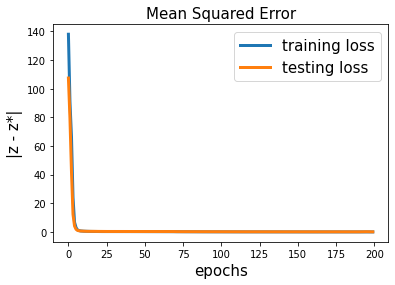

In [ ]:
# ---------------------------------------------
# Plot testing history
# ---------------------------------------------
import matplotlib.pyplot as plt

fig1 = plt.figure(1)
plt.plot(train_loss_hist, linewidth=3)
plt.plot(test_loss_hist, linewidth=3)
plt.legend(['training loss', 'testing loss'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('|z - z*|', fontsize=15)
plt.title('Mean Squared Error', fontsize=15)
plt.savefig('line_plot.pdf')  

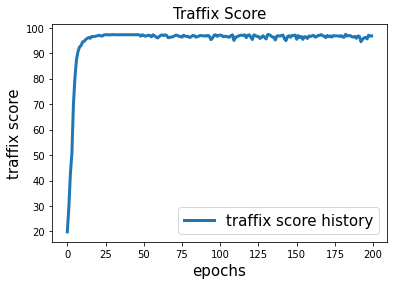

In [ ]:
fig1 = plt.figure(2)
plt.plot(traffix_score_hist, linewidth=3)
plt.legend(['traffix score history'], fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('traffix score', fontsize=15)
plt.title('Traffix Score', fontsize=15)
plt.savefig('traffix_score_plot.pdf')  

## Generate CSV File

In [ ]:
filename = data_set + '_epoch_vs_relerr.csv'
with open(filename, 'w') as f: 
  for epoch, rel_err in enumerate(rel_err_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, rel_err)) 

filename = data_set + '_epoch_vs_trafix.csv'
with open(filename, 'w') as f: 
  for epoch, traffix_score in enumerate(traffix_score_hist):     
    f.write('%0.5e,%0.5e\n' % (epoch + 1, traffix_score)) 